In [53]:
# job_prediction_training.ipynb
# Jupyter Notebook for Job Application Success Prediction Model Training

import re
import os
import spacy
import json
import joblib
import inspect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Self 
from datetime import datetime
from scipy.sparse import csr_matrix, vstack
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    r2_score,
    explained_variance_score
)
from langdetect import detect
from spacy.lang.en.stop_words import STOP_WORDS as EN_STOP_WORDS
from spacy.lang.de.stop_words import STOP_WORDS as DE_STOP_WORDS

import warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [75]:
# Global constants

MODEL_VERSION = "1.0"

TECH_KEYWORDS = {
    'python': r'\bpython\b',
    'scala': r'\bscala\b',
    'spark': r'\bspark\b|\bpyspark\b',
    'kafka': r'\bkafka\b',
    'airflow': r'\bairflow\b',
    'mongodb': r'\bmongo(db)?\b',
    'flask': r'\bflask\b',
    'sql': r'\bsql\b|\bpostgresql\b|\bpl/pgsql\b',
    'docker': r'\bdocker\b',
    'tensorflow': r'\btensorflow\b',
    'fastapi': r'\bfastapi\b'
}

INDUSTRY_PATTERNS = {
    'en': {
        'finance': (
            r'\b(financ|bank|invest|accounting|'
            r'audit|tax|trad|republic|brokerage)\w*\b'
        ),
        'healthcare': (
            r'\b(health|medical|pharma|'
            r'hospital|clinic|patient)\w*\b'
        ),
        'tech': (
            r'\b(tech|software|it|computer|system|'
            r'developer|engineer|ai|artificial intelligence|'
            r'deep learning|machine learning|cloud|data science)\w*\b'
        ),
        'manufacturing': (
            r'\b(manufactur|production|factory|'
            r'plant|assembly|automotive|car|vehicle)\w*\b'
        ),
        'retail': (
            r'\b(retail|store|shop|'
            r'e.?commerce|merchandis)\w*\b'
        ),
        'logistics': (
            r'\b(logistics|delivery|'
            r'supply chain|transport|shipping)\w*\b'
        ),
        'food': r'\b(food|grocery|restaurant|meal)\w*\b',
        'telecom': r'\b(telecom|telecommunication|mobile network)\w*\b',
        'energy': r'\b(energy|solar|renewable|power|electric)\w*\b',
        'aerospace': r'\b(aerospace|aviation|space|satellite)\w*\b',
        'consulting': r'\b(consult|advisory)\w*\b',
        'insurance': r'\b(insurance|actuar)\w*\b',
        'gaming': r'\b(game|gaming)\w*\b',
        'social': r'\b(social media|social network)\w*\b',
        'semiconductor': r'\b(semiconductor|chip|microelectronic)\w*\b'
    },
    'de': {
        'finance': (
            r'\b(finan|bank|invest|buchhalt|'
            r'rechnungs|steuer|handel)\w*\b'
        ),
        'healthcare': (
            r'\b(gesundheit|medizin|pharma|'
            r'krankenhaus|klinik|patient)\w*\b'
        ),
        'tech': (
            r'\b(tech|software|it|computer|system|'
            r'entwickler|ingenieur|ki|künstliche intelligenz|'
            r'maschinelles lernen|datenwissenschaft)\w*\b'
        ),
        'manufacturing': (
            r'\b(produktion|fabrik|werk|'
            r'montage|herstellung|auto|fahrzeug)\w*\b'
        ),
        'retail': (
            r'\b(einzelhandel|laden|'
            r'geschäft|e.?commerce|handel)\w*\b'
        ),
        'logistics': r'\b(logistik|lieferung|transport)\w*\b',
        'food': r'\b(lebensmittel|nahrung|restaurant|mahlzeit)\w*\b',
        'telecom': r'\b(telekommunikation|mobilfunk)\w*\b',
        'energy': r'\b(energie|solar|erneuerbar|strom)\w*\b',
        'aerospace': r'\b(luftfahrt|raumfahrt|satellit)\w*\b',
        'consulting': r'\b(beratung|berater)\w*\b',
        'insurance': r'\b(versicherung)\w*\b',
        'gaming': r'\b(spiel|gaming)\w*\b',
        'social': r'\b(soziale medien)\w*\b',
        'semiconductor': r'\b(hälbleiter|chip|mikroelektronik)\w*\b'
    }
}

LANGUAGE_PATTERNS = {
    'german': re.compile(
        r'(?:fließend|verhandlungssicher|gut|geschäftssicher|erforderlich|voraussetzung|kenntnisse|sprachkenntnisse)\s+deutsch|'
        r'deutsch\s*(?:kenntnisse|erforderlich|voraussetzung|sprachkenntnisse|erwünscht|muss|sollte)|'
        r'german\s+(?:required|necessary|fluent|proficient|knowledge|skills|language)|'  # Added 'language'
        r'deutschkenntnisse|'
        r'german\s+language',
        re.IGNORECASE
    ),
    
    'english': re.compile(
        r'english\s+(?:fluent|proficient|required|necessary|working\s+knowledge|skills)|'
        r'englisch\s+(?:fließend|verhandlungssicher|erforderlich|voraussetzung|kenntnisse)|'
        r'business\s+english|'
        r'englischkenntnisse',
        re.IGNORECASE
    ),
    
    'german_levels': {
        'A1': re.compile(r'A1|A1\s*deutsch|grundkenntnisse|anfängerkenntnisse|basic\s+german', re.IGNORECASE),
        'A2': re.compile(r'A2|A2\s*deutsch|basiskenntnisse|einfache\s+konversation|elementary', re.IGNORECASE),
        'B1': re.compile(r'B1|B1\s*deutsch|fortgeschrittene\s+kenntnisse|selbständige\s+sprachverwendung|intermediate', re.IGNORECASE),
        'B2': re.compile(r'B2|B2\s*deutsch|gute\s+kenntnisse|berufsbezogene\s+sprachkenntnisse|good|confident', re.IGNORECASE),  # Added simple 'B2'
        'C1': re.compile(r'C1|C1\s*deutsch|verhandlungssicher|fließend|geschäftssicher|advanced|fluent|business', re.IGNORECASE),
        'C2': re.compile(r'C2|C2\s*deutsch|muttersprachlich|herausragende\s+kenntnisse|native|proficient', re.IGNORECASE)
    }
}

SENIORITY_PATTERNS = {
    'senior': re.compile(r'\bsenior\b', re.IGNORECASE),
    'junior': re.compile(r'\bjunior\b', re.IGNORECASE)
}

In [55]:
# Configuration for local data
class Config:
    BASE_DIR = Path.cwd().parent.parent
    
    DATA_FILE = BASE_DIR / "data" / "samples" / "job_applications.json"
    MODEL_DIR = BASE_DIR / "app" / "services" / "job_predictor" / "models"
    SPACY_MODEL_DIR = BASE_DIR / "app" / "services" / "job_predictor" / "models" / "spacy"
    RANDOM_STATE = 42

config = Config()

# Create directories if they don't exist
os.makedirs(config.DATA_FILE.parent, exist_ok=True)
os.makedirs(config.MODEL_DIR, exist_ok=True)
os.makedirs(config.SPACY_MODEL_DIR, exist_ok=True)

print(f"Data file path: {config.DATA_FILE}")
print(f"Model directory: {config.MODEL_DIR}")
print(f"Spacy directory: {config.SPACY_MODEL_DIR}")

Data file path: /home/aleksei/Projects/job_tracker/data/samples/job_applications.json
Model directory: /home/aleksei/Projects/job_tracker/app/services/job_predictor/models
Spacy directory: /home/aleksei/Projects/job_tracker/app/services/job_predictor/models/spacy


In [56]:
# Initialize spaCy models with custom paths
def load_spacy_model(
        model_name: str,
        custom_path: str | None = None
) -> None:
    """Load spaCy model from custom path or default location."""
    try:
        if custom_path and os.path.exists(custom_path):
            # Try custom path first
            model_path = os.path.join(custom_path, model_name)
            if os.path.exists(model_path):
                return spacy.load(model_path)

        # Fallback to default loading
        return spacy.load(model_name)
        
    except OSError:
        print(f"⚠️  {model_name} not found. Please download it:")
        print(f"   python -m spacy download {model_name} --direct --model-path {custom_path}")
        return None

# Load models with custom paths
nlp_de = load_spacy_model("de_core_news_sm", config.SPACY_MODEL_DIR)
nlp_en = load_spacy_model("en_core_web_sm", config.SPACY_MODEL_DIR)

⚠️  de_core_news_sm not found. Please download it:
   python -m spacy download de_core_news_sm --direct --model-path /home/aleksei/Projects/job_tracker/app/services/job_predictor/models/spacy
⚠️  en_core_web_sm not found. Please download it:
   python -m spacy download en_core_web_sm --direct --model-path /home/aleksei/Projects/job_tracker/app/services/job_predictor/models/spacy


In [57]:
# Enhanced text preprocessing with fallback
def preprocess_text(text: str, lang: str) -> str:
    """Language-specific preprocessing with robust error handling."""
    if not isinstance(text, str) or not text.strip():
        return ""
    
    try:
        if lang == 'de' and nlp_de is not None:
            doc = nlp_de(text)
        elif nlp_en is not None:
            doc = nlp_en(text)
        else:
            # Fallback: simple tokenization without spaCy
            return simple_tokenize(text)
        
        return " ".join([
            token.lemma_.lower() for token in doc 
            if not token.is_stop and token.is_alpha
        ])
        
    except Exception as e:
        print(f"⚠️  spaCy processing failed: {e}")
        return simple_tokenize(text)

def simple_tokenize(text: str) -> str:
    """Fallback tokenization without spaCy."""
    # Basic tokenization and cleaning
    tokens = re.findall(r'\b[a-zA-ZäöüÄÖÜß]+\b', text.lower())
    # Remove stopwords (basic lists)
    en_stopwords = {'the', 'and', 'is', 'in', 'to', 'of', 'for', 'with', 'on', 'at'}
    de_stopwords = {'der', 'die', 'das', 'und', 'in', 'zu', 'den', 'von', 'mit', 'für'}
    stopwords = en_stopwords.union(de_stopwords)
    
    return " ".join([token for token in tokens if token not in stopwords])

In [58]:
# Data Loading from JSON file
def load_training_data(file_path: str) -> pd.DataFrame:
    """Load training data that matches the application data model."""
    try:
        file_path = Path(file_path)
        if not file_path.exists():
            raise FileNotFoundError(f"Data file not found: {file_path}")
        
        with open(file_path, 'r') as f:
            data = json.load(f)
        
        df = pd.DataFrame(data)
        
        # Convert date strings to datetime objects
        date_columns = ['applied_date', 'response_date', 'last_prediction_date']
        for col in date_columns:
            if col in df.columns:
                df[col] = pd.to_datetime(df[col])
        
        # Extract ml_meta fields (matches data model structure)
        if 'ml_meta' in df.columns:
            ml_fields = ['success_probability', 'german_level', 'last_prediction_date']
            for field in ml_fields:
                df[field] = df['ml_meta'].apply(
                    lambda x: x.get(field) if isinstance(x, dict) else None
                )

        if 'last_prediction_date' in df.columns:
            df['last_prediction_date'] = pd.to_datetime(df['last_prediction_date'])

        print(f"📊 Loaded {len(df)} records from {file_path}")
        return df
        
    except FileNotFoundError as e:
        print(f"❌ {e}")
        print("💡 Please run data_generator.py first to create sample data")
        return pd.DataFrame()
    except Exception as e:
        print(f"❌ Error loading data: {e}")
        return pd.DataFrame()

# Load data
df = load_training_data(config.DATA_FILE)

📊 Loaded 1000 records from /home/aleksei/Projects/job_tracker/data/samples/job_applications.json


📈 Data Exploration
Dataset shape: (1000, 16)

📋 Data Types:
company                         object
location                        object
role                            object
status                          object
source                          object
applied_date            datetime64[ns]
response_date           datetime64[ns]
response_days                  float64
notes                           object
vacancy_description             object
description_lang                object
ml_meta                         object
requirements                    object
success_probability            float64
german_level                    object
last_prediction_date    datetime64[ns]
dtype: object

🔍 Missing Values:
company                   0
location                  0
role                      0
status                    0
source                    0
applied_date              0
response_date           297
response_days           297
notes                   259
vacancy_description       0
des

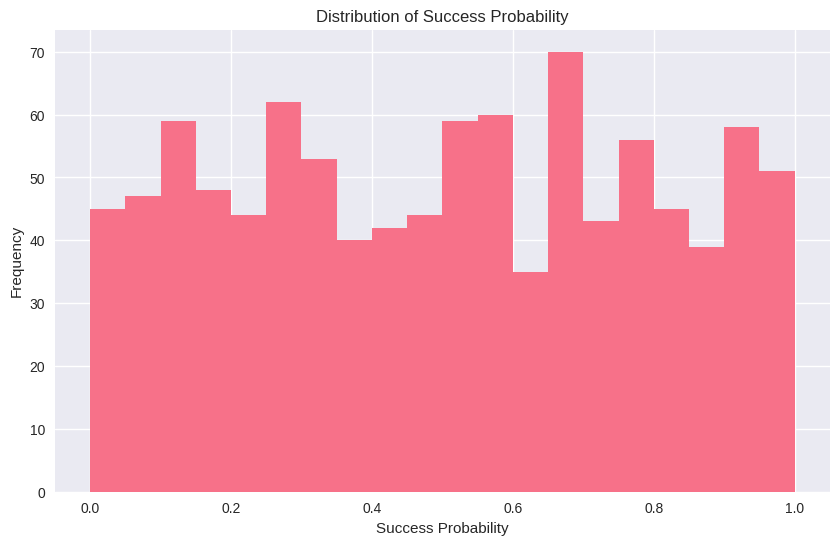

In [59]:
# Data Exploration
if not df.empty:
    print("📈 Data Exploration")
    print(f"Dataset shape: {df.shape}")
    print("\n📋 Data Types:")
    print(df.dtypes)
    print("\n🔍 Missing Values:")
    print(df.isnull().sum())
    
    if 'success_probability' in df.columns:
        print("\n🎯 Target Distribution:")
        print(df['success_probability'].describe())
        plt.figure(figsize=(10, 6))
        df['success_probability'].hist(bins=20)
        plt.title('Distribution of Success Probability')
        plt.xlabel('Success Probability')
        plt.ylabel('Frequency')
        plt.show()

In [60]:
# Feature Engineering (Updated for local data)
def create_enhanced_features(df: pd.DataFrame) -> pd.DataFrame:
    """Feature engineering pipeline matching production code."""
    df = df.copy()
    
    # Language detection
    df['description_lang'] = df['vacancy_description'].apply(
        lambda x: detect(x[:500]) if isinstance(x, str) and len(x) > 0 else 'en'
    )

    # Tech stack extraction
    def extract_tech_stack(description: str) -> dict:
        if not isinstance(description, str):
            return {}
        return {
            tech: int(bool(re.search(pattern, description.lower())))
            for tech, pattern in TECH_KEYWORDS.items()
        }
    
    df['tech_stack'] = df['vacancy_description'].apply(extract_tech_stack)
    
    # Language requirements
    def extract_language_requirements(description: str) -> dict:
        if not isinstance(description, str):
            return {'german_required': False, 'english_required': False, 'german_level': None}
        
        requirements = {
            'german_required': bool(LANGUAGE_PATTERNS['german'].search(description)),
            'english_required': bool(LANGUAGE_PATTERNS['english'].search(description)),
            'german_level': None
        }

        if requirements['german_required']:
            for level, pattern in LANGUAGE_PATTERNS['german_levels'].items():
                if pattern.search(description):
                    requirements['german_level'] = level
                    break

        return requirements
    
    df['language_reqs'] = df['vacancy_description'].apply(extract_language_requirements)
    
    # Industry focus
    def extract_industry_focus(description: str, lang: str = 'en') -> str:
        if not isinstance(description, str):
            return 'other'
        
        description_lower = description.lower()
        patterns = INDUSTRY_PATTERNS.get(lang, INDUSTRY_PATTERNS['en'])

        for industry, pattern in patterns.items():
            if re.search(pattern, description_lower):
                return industry
        return 'other'

    df['industry'] = df.apply(
        lambda x: extract_industry_focus(x['vacancy_description'], x['description_lang']),
        axis=1
    )

    # Seniority level
    def calculate_seniority(role):
        if not isinstance(role, str):
            return 0
        role_lower = role.lower()
        if SENIORITY_PATTERNS['senior'].search(role_lower):
            return 1
        elif SENIORITY_PATTERNS['junior'].search(role_lower):
            return -1
        return 0
    
    df['relative_seniority'] = df['role'].apply(calculate_seniority)
    
    # Enhanced text preprocessing with fallback
    def preprocess_text(text: str, lang: str) -> str:
        """Language-specific preprocessing with robust error handling."""
        if not isinstance(text, str) or not text.strip():
            return ""
        
        try:
            if lang == 'de' and nlp_de is not None:
                doc = nlp_de(text)
            elif nlp_en is not None:
                doc = nlp_en(text)
            else:
                # Fallback: simple tokenization without spaCy
                return simple_tokenize(text)
            
            return " ".join([
                token.lemma_.lower() for token in doc 
                if not token.is_stop and token.is_alpha
            ])
            
        except Exception as e:
            print(f"⚠️  spaCy processing failed: {e}")
            return simple_tokenize(text)

    def simple_tokenize(text: str) -> str:
        """Fallback tokenization without spaCy."""
        # Basic tokenization and cleaning
        tokens = re.findall(r'\b[a-zA-ZäöüÄÖÜß]+\b', text.lower())
        # Remove stopwords (basic lists)
        en_stopwords = {'the', 'and', 'is', 'in', 'to', 'of', 'for', 'with', 'on', 'at'}
        de_stopwords = {'der', 'die', 'das', 'und', 'in', 'zu', 'den', 'von', 'mit', 'für'}
        stopwords = en_stopwords.union(de_stopwords)
        
        return " ".join([token for token in tokens if token not in stopwords])

    df['processed_text'] = df.apply(
        lambda x: preprocess_text(x['vacancy_description'], x['description_lang']),
        axis=1
    )

    # Expand language requirements
    lang_reqs = pd.json_normalize(df['language_reqs'])
    df = pd.concat([df, lang_reqs.add_prefix('lang_')], axis=1)

    df.drop(columns=['language_reqs'], inplace=True, errors='ignore')
    
    return df

In [61]:
# Apply Production Feature Engineering
if not df.empty:
    enhanced_df = create_enhanced_features(df)
    print("✅ Production feature engineering completed")
    print(f"Enhanced dataset shape: {enhanced_df.shape}")
    print(f"Available features: {list(enhanced_df.columns)}")
    enhanced_df.head()
else:
    enhanced_df = pd.DataFrame()
    print("⚠️  No data available for feature engineering")

✅ Production feature engineering completed
Enhanced dataset shape: (1000, 23)
Available features: ['company', 'location', 'role', 'status', 'source', 'applied_date', 'response_date', 'response_days', 'notes', 'vacancy_description', 'description_lang', 'ml_meta', 'requirements', 'success_probability', 'german_level', 'last_prediction_date', 'tech_stack', 'industry', 'relative_seniority', 'processed_text', 'lang_german_required', 'lang_english_required', 'lang_german_level']


In [62]:
# Data Preparation
def prepare_training_data(
        enhanced_df: pd.DataFrame,
        target_column='success_probability'
) -> tuple[pd.DataFrame, pd.Series, pd.Series]:
    """Prepare data for training from enhanced features."""
    if enhanced_df.empty:
        return pd.DataFrame(), pd.Series(), pd.Series()
    
    # Filter out missing target values
    df_clean = enhanced_df.dropna(subset=[target_column])
    
    if df_clean.empty:
        print("⚠️  No data with target values available")
        return pd.DataFrame(), pd.Series(), pd.Series()
    
    # Separate features and target
    X = df_clean
    y = df_clean[target_column] 
 
    print(f"📊 Final training set: {X.shape[0]} samples")
    print(f"🎯 Target distribution: {pd.Series(y).mean()} mean")
    
    return X, y

if not enhanced_df.empty:
    X, y = prepare_training_data(enhanced_df)
else:
    X, y = pd.DataFrame(), pd.Series()

📊 Final training set: 1000 samples
🎯 Target distribution: 0.50095 mean


In [63]:
# TechStackTransformer Class
class TechStackTransformer(BaseEstimator, TransformerMixin):
    """Transforms a column of tech stack dicts into a feature matrix."""
    
    def __init__(self: Self) -> None:
        """Initialize the transformer."""
        self.feature_names_ = None
        self.tech_keywords_ = list(TECH_KEYWORDS.keys())
    
    def fit(self: Self, X: pd.DataFrame, y: pd.Series = None) -> Self:
        """Learn the feature names from the tech stack dictionaries."""
        self.feature_names_ = sorted(self.tech_keywords_)
        return self
    
    def transform(self: Self, X: pd.DataFrame) -> pd.DataFrame:
        """Transform tech stack dicts into a binary feature matrix."""
        if self.feature_names_ is None:
            raise ValueError("Must call fit() before transform()")
        
        # Handle both Series and DataFrame input
        if isinstance(X, pd.DataFrame):
            tech_series = X['tech_stack']
        else:
            tech_series = X
        
        # Create a DataFrame with 0/1 values for each tech
        transformed_data = []
        for tech_dict in tech_series:
            row = {tech: 0 for tech in self.feature_names_}
            if isinstance(tech_dict, dict):
                for tech, value in tech_dict.items():
                    if tech in row and value:
                        row[tech] = 1
            transformed_data.append(row)
        
        return pd.DataFrame(transformed_data, columns=self.feature_names_)

    def get_feature_names_out(self: Self) -> list[str]:
        """Get output feature names for transformation."""
        if self.feature_names_ is None:
            raise ValueError("Transformer not fitted yet")
        return self.feature_names_

In [64]:
class LanguageAwareTfidf(BaseEstimator, TransformerMixin):
    """Language-aware TF-IDF vectorizer."""
    
    def __init__(self: Self, max_features: int = 50) -> None:
        """Initialize the language-aware vectorizer."""
        self.max_features = max_features
        self.vectorizer_en = TfidfVectorizer(
            max_features=max_features,
            stop_words=list(EN_STOP_WORDS)
        )
        self.vectorizer_de = TfidfVectorizer(
            max_features=max_features,
            stop_words=list(DE_STOP_WORDS)
        )
        self.feature_names_ = None
        self.has_en_data = False
        self.has_de_data = False

    def fit(self: Self, X: pd.DataFrame, y=None) -> Self:
        """Fit the vectorizers to English and German text subsets."""
        if not {'processed_text', 'description_lang'}.issubset(X.columns):
            raise ValueError(
                f"Input DataFrame must contain 'processed_text' "
                f"and 'description_lang' columns"
            )
        
        texts_en = X[X['description_lang'] == 'en']['processed_text']
        texts_de = X[X['description_lang'] == 'de']['processed_text']

        self.has_en_data = not texts_en.empty
        self.has_de_data = not texts_de.empty

        if self.has_en_data:
            self.vectorizer_en.fit(texts_en)
        if self.has_de_data:
            self.vectorizer_de.fit(texts_de)

        # Build feature names
        en_features = [
            f"en_{f}" for f in self.vectorizer_en.get_feature_names_out()
        ] if self.has_en_data else []
        
        de_features = [
            f"de_{f}" for f in self.vectorizer_de.get_feature_names_out()
        ] if self.has_de_data else []
 
        self.feature_names_ = en_features + de_features

        return self

    def transform(self: Self, X: pd.DataFrame) -> csr_matrix:
        """Transform text data into a combined TF-IDF feature matrix."""
        results = []
        for _, row in X.iterrows():
            text = row['processed_text']
            lang = row['description_lang']
            
            if lang == 'en' and self.has_en_data:
                results.append(self.vectorizer_en.transform([text]))
            elif lang == 'de' and self.has_de_data:
                results.append(self.vectorizer_de.transform([text]))
            else:
                if self.has_en_data:
                    empty_vec = csr_matrix((1, len(self.vectorizer_en.get_feature_names_out())))
                elif self.has_de_data:
                    empty_vec = csr_matrix((1, len(self.vectorizer_de.get_feature_names_out())))
                else:
                    empty_vec = csr_matrix((1, 0))
                results.append(empty_vec)

        if results:
            return vstack(results)
        return csr_matrix((len(X), 0))
    
    def get_feature_names_out(self: Self) -> list[str]:
        """Get output feature names with language prefixes."""
        if self.feature_names_ is None:
            raise ValueError("Transformer not fitted yet")
        return self.feature_names_

In [65]:
# Create Pipeline
def create_pipeline() -> Pipeline:
    """Create the model pipeline matching production."""
    preprocessor = make_column_transformer(
        (TechStackTransformer(), ['tech_stack']),
        (OneHotEncoder(handle_unknown='ignore', sparse_output=False), ['industry']),
        (OneHotEncoder(handle_unknown='ignore', sparse_output=False), ['source']),
        (OneHotEncoder(handle_unknown='ignore', sparse_output=False), ['lang_german_level']),
        ('passthrough', ['relative_seniority', 'lang_german_required', 'lang_english_required']),
        (LanguageAwareTfidf(max_features=50), ['processed_text', 'description_lang']),
        remainder='drop'
    )

    return make_pipeline(
        preprocessor,
        GradientBoostingRegressor(
            n_estimators=150,
            learning_rate=0.05,
            max_depth=4,
            random_state=config.RANDOM_STATE,
            verbose=1,
            loss='squared_error'
        )
    )

pipeline = create_pipeline()
print("✅ Pipeline created successfully")

✅ Pipeline created successfully


In [66]:
# Train-Test Split
if not enhanced_df.empty and 'success_probability' in enhanced_df.columns:
    y = enhanced_df['success_probability']
    
    X_train, X_test, y_train, y_test = train_test_split(
        enhanced_df.drop(columns=['success_probability']),
        y,
        test_size=0.2,
        random_state=config.RANDOM_STATE,
        stratify=None
    )

    print(f"📊 Train set: {X_train.shape[0]} samples")
    print(f"📊 Test set: {X_test.shape[0]} samples")
    print(f"🎯 Target range - Train: [{y_train.min():.3f}, {y_train.max():.3f}]")
    print(f"🎯 Target range - Test: [{y_test.min():.3f}, {y_test.max():.3f}]")
    print(f"📈 Target mean - Train: {y_train.mean():.3f}, Test: {y_test.mean():.3f}")
    
    # Show available features for debugging (exclude target)
    feature_columns = [col for col in enhanced_df.columns if col != 'success_probability']
    print(f"🔧 Features available: {feature_columns}")
else:
    print("⚠️  No data available for training")
    X_train, X_test, y_train, y_test = pd.DataFrame(), pd.DataFrame(), pd.Series(), pd.Series()

📊 Train set: 800 samples
📊 Test set: 200 samples
🎯 Target range - Train: [0.000, 1.000]
🎯 Target range - Test: [0.010, 0.990]
📈 Target mean - Train: 0.494, Test: 0.531
🔧 Features available: ['company', 'location', 'role', 'status', 'source', 'applied_date', 'response_date', 'response_days', 'notes', 'vacancy_description', 'description_lang', 'ml_meta', 'requirements', 'german_level', 'last_prediction_date', 'tech_stack', 'industry', 'relative_seniority', 'processed_text', 'lang_german_required', 'lang_english_required', 'lang_german_level']


In [67]:
print("🔍 Language distribution in training data:")
print(X_train['description_lang'].value_counts())

print("\n🔍 Sample of German texts (if any):")
german_texts = X_train[X_train['description_lang'] == 'de']['processed_text']
if not german_texts.empty:
    print(f"Found {len(german_texts)} German texts")
    print(f"Sample: {german_texts.iloc[0][:100]}...")
else:
    print("No German texts found in training data")

🔍 Language distribution in training data:
description_lang
en    550
de    250
Name: count, dtype: int64

🔍 Sample of German texts (if any):
Found 250 German texts
Sample: zur verstärkung unseres teams suchen wir einen senior data engineer jahre erfahrung optimierung perf...


In [68]:
# Quick debugging script
def check_transformer_signatures(pipeline: Pipeline) -> None:
    """Check if all transformers have correct fit method signatures."""
    for step_name, transformer in pipeline.steps:
        if hasattr(transformer, 'fit'):
            # Check if fit method accepts y parameter
            sig = inspect.signature(transformer.fit)
            params = list(sig.parameters.keys())

            if len(params) < 2 or 'y' not in params[1:]:
                print(f"❌ {step_name}: {type(transformer).__name__} has incorrect fit signature")
                print(f"   Expected: fit(self, X, y=None)")
                print(f"   Actual: {str(sig)}")
            else:
                print(f"✅ {step_name}: {type(transformer).__name__} has correct fit signature")

print("🔍 Checking transformer signatures...")
check_transformer_signatures(pipeline)

🔍 Checking transformer signatures...
✅ columntransformer: ColumnTransformer has correct fit signature
✅ gradientboostingregressor: GradientBoostingRegressor has correct fit signature


In [69]:
# Model Training (Complete with debugging)
print("=" * 60)
print("🚀 MODEL TRAINING WITH PRODUCTION FEATURES")
print("=" * 60)

if not X_train.empty and not y_train.empty:
    print("📊 Starting training...")
    print(f"   Training samples: {X_train.shape[0]}")
    print(f"   Features available: {X_train.shape[1]}")
    print(f"   Target distribution: {pd.Series(y_train).value_counts().to_dict()}")
    
    # Debug: Show what columns we have
    print(f"   Column types:")
    for col in ['tech_stack', 'industry', 'source', 'lang_german_level', 
                'relative_seniority', 'processed_text', 'description_lang']:
        if col in X_train.columns:
            sample_val = X_train[col].iloc[0] if not X_train.empty else None
            print(f"     {col}: {type(sample_val)} - Example: {sample_val}")
    
    start_time = datetime.now()
    
    try:
        # Create the production-equivalent pipeline
        print("🔧 Creating pipeline...")
        pipeline = create_pipeline()
        
        # Show pipeline structure
        print("📋 Pipeline steps:")
        for i, (name, transformer) in enumerate(pipeline.steps):
            print(f"   {i+1}. {name}: {type(transformer).__name__}")
            
            # Show column transformer details if it's the first step
            if i == 0 and hasattr(transformer, 'transformers'):
                print("      Transformers:")
                for trans_name, trans, cols in transformer.transformers:
                    print(f"        - {trans_name}: {type(trans).__name__} on {cols}")
        
        # Fit the pipeline
        print("🎯 Fitting pipeline...")
        pipeline.fit(X_train, y_train)
        
        training_time = datetime.now() - start_time
        print(f"✅ Training completed in {training_time}")
        
        # Check if pipeline was fitted successfully
        if hasattr(pipeline, 'fit'):
            print("🎉 Pipeline fitted successfully!")
            
            # Test a quick prediction to verify it works
            try:
                sample_pred = pipeline.predict(X_train.head(1))
                print(f"🧪 Quick test prediction: {sample_pred[0]}")
            except Exception as e:
                print(f"⚠️  Test prediction failed: {e}")
        
    except Exception as e:
        print(f"❌ Training failed: {e}")
        import traceback
        print("🔍 Stack trace:")
        traceback.print_exc()
        
        # Debug: Check specific column issues
        print("\n🐛 Debugging column issues:")
        for col in ['tech_stack', 'processed_text', 'description_lang']:
            if col in X_train.columns:
                non_null_count = X_train[col].notna().sum()
                print(f"   {col}: {non_null_count} non-null values")
                if X_train[col].notna().any():
                    sample = X_train[col].dropna().iloc[0]
                    print(f"     Sample: {sample} (type: {type(sample)})")
        
        pipeline = None
        
else:
    print("⚠️  No training data available")
    print(f"   X_train empty: {X_train.empty}")
    print(f"   y_train empty: {y_train.empty if hasattr(y_train, 'empty') else 'N/A'}")
    
    if not enhanced_df.empty:
        print(f"   enhanced_df shape: {enhanced_df.shape}")
        print(f"   enhanced_df columns: {list(enhanced_df.columns)}")
        if 'success_probability' in enhanced_df.columns:
            target_not_null = enhanced_df['success_probability'].notna().sum()
            print(f"   Non-null target values: {target_not_null}")
    
    pipeline = None

🚀 MODEL TRAINING WITH PRODUCTION FEATURES
📊 Starting training...
   Training samples: 800
   Features available: 22
   Target distribution: {0.65: 16, 0.18: 16, 0.3: 15, 0.31: 13, 0.13: 13, 0.88: 13, 0.51: 12, 0.32: 12, 0.56: 11, 0.7: 11, 0.81: 11, 0.02: 11, 0.5: 11, 0.95: 11, 0.46: 11, 0.58: 10, 0.83: 10, 0.17: 10, 0.25: 10, 0.09: 10, 0.54: 10, 0.12: 10, 0.44: 10, 0.93: 10, 0.99: 9, 0.01: 9, 0.77: 9, 0.38: 9, 0.6: 9, 0.42: 9, 0.11: 9, 0.72: 9, 0.07: 9, 0.61: 9, 0.22: 9, 0.73: 9, 0.79: 9, 0.57: 9, 0.76: 9, 0.53: 9, 0.96: 8, 0.1: 8, 0.74: 8, 0.16: 8, 0.97: 8, 0.24: 8, 0.34: 8, 0.28: 8, 0.87: 8, 0.48: 8, 0.36: 8, 0.68: 8, 0.29: 8, 0.78: 8, 0.47: 8, 0.55: 8, 0.41: 8, 0.26: 8, 0.37: 8, 0.92: 8, 0.19: 7, 0.69: 7, 0.63: 7, 0.91: 7, 0.89: 7, 0.23: 7, 0.03: 6, 0.9: 6, 0.39: 6, 0.05: 6, 0.06: 6, 0.59: 6, 0.08: 6, 0.2: 6, 0.67: 6, 1.0: 6, 0.62: 6, 0.66: 6, 0.94: 6, 0.27: 6, 0.98: 6, 0.15: 6, 0.71: 5, 0.45: 5, 0.35: 5, 0.82: 5, 0.64: 5, 0.52: 5, 0.04: 5, 0.8: 5, 0.49: 5, 0.21: 5, 0.85: 4, 0.75: 4

📊 Model Evaluation with Production Features
📈 Train R² Score: 0.4372
📈 Test R² Score: -0.0711
📈 Mean Squared Error (MSE): 0.0906
📈 Root Mean Squared Error (RMSE): 0.3011
📈 Mean Absolute Error (MAE): 0.2600
📈 R² Score: -0.0711
📈 Explained Variance Score: -0.0501
📈 Max Prediction Error: 0.7216
📈 Mean Prediction: 0.4885
📈 Std of Predictions: 0.0952


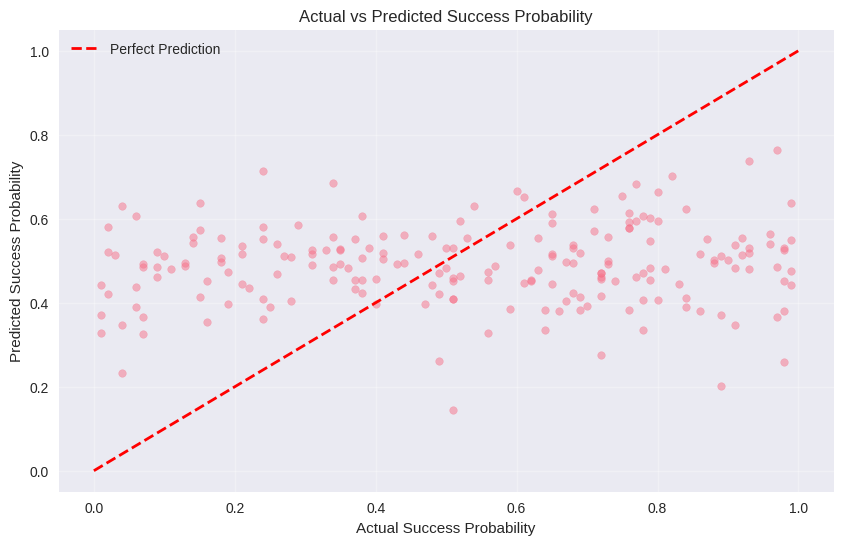

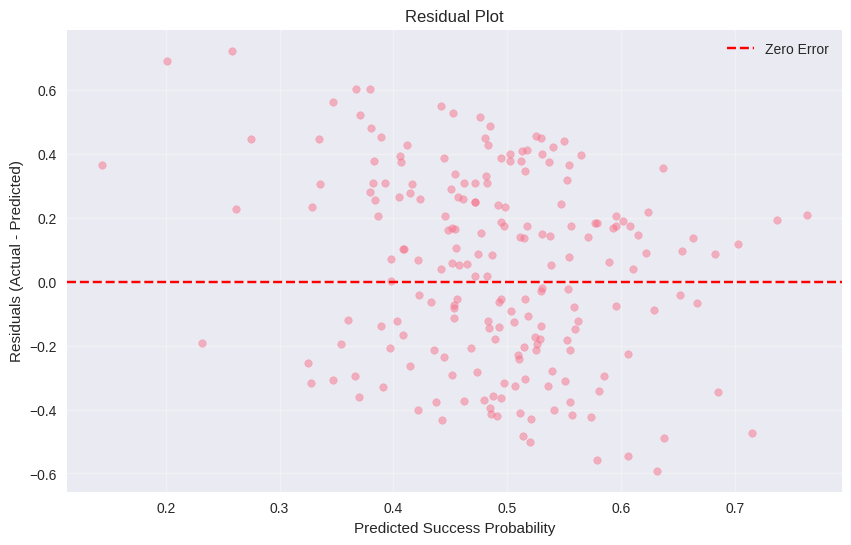

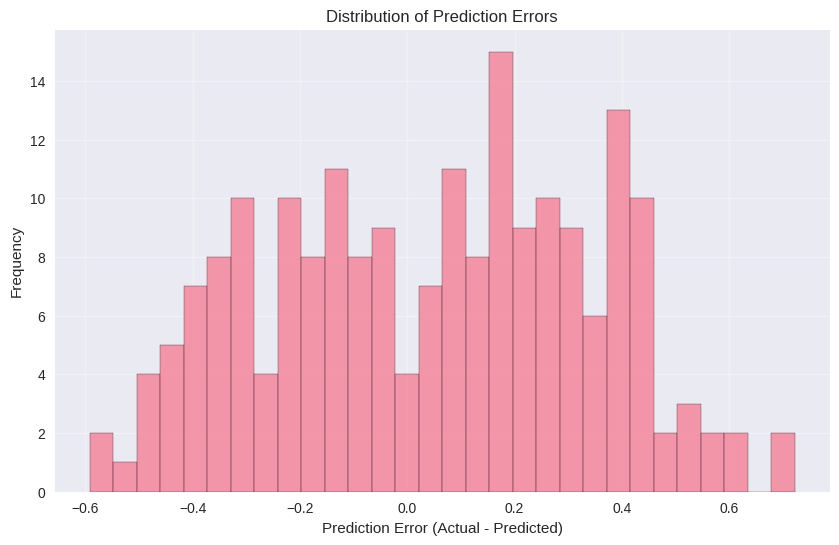

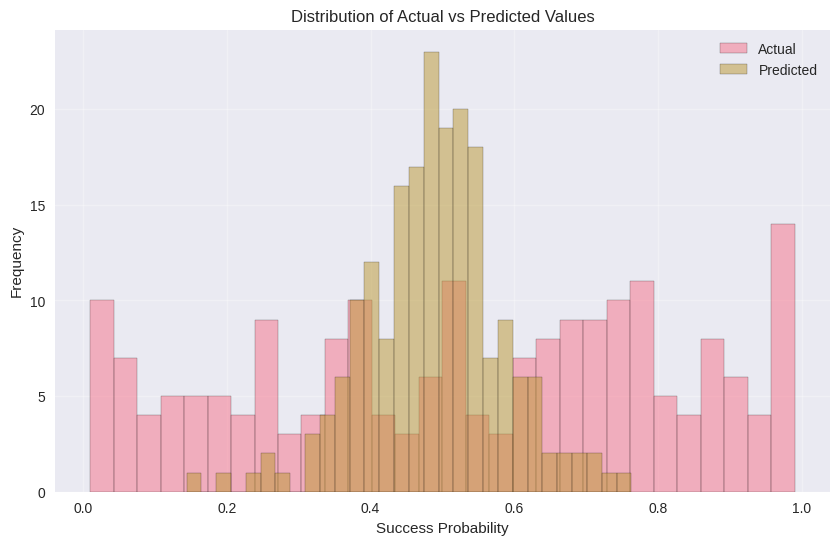

In [70]:
# Model Evaluation for Regression
if pipeline is not None and not X_test.empty:
    print("📊 Model Evaluation with Production Features")
    print("=" * 50)
    
    try:
        # Predictions
        y_pred = pipeline.predict(X_test)
        
        # Calculate regression metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        evs = explained_variance_score(y_test, y_pred)
        
        # Training score
        train_score = pipeline.score(X_train, y_train)
        test_score = pipeline.score(X_test, y_test)

        print(f"📈 Train R² Score: {train_score:.4f}")
        print(f"📈 Test R² Score: {test_score:.4f}")
        print(f"📈 Mean Squared Error (MSE): {mse:.4f}")
        print(f"📈 Root Mean Squared Error (RMSE): {rmse:.4f}")
        print(f"📈 Mean Absolute Error (MAE): {mae:.4f}")
        print(f"📈 R² Score: {r2:.4f}")
        print(f"📈 Explained Variance Score: {evs:.4f}")

        # Additional useful metrics for probability prediction
        print(f"📈 Max Prediction Error: {abs(y_test - y_pred).max():.4f}")
        print(f"📈 Mean Prediction: {y_pred.mean():.4f}")
        print(f"📈 Std of Predictions: {y_pred.std():.4f}")

        # Scatter plot of predictions vs actual
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, y_pred, alpha=0.5, s=30)
        plt.plot([0, 1], [0, 1], 'r--', lw=2, label='Perfect Prediction')
        plt.xlabel('Actual Success Probability')
        plt.ylabel('Predicted Success Probability')
        plt.title('Actual vs Predicted Success Probability')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

        # Residual plot
        residuals = y_test - y_pred
        plt.figure(figsize=(10, 6))
        plt.scatter(y_pred, residuals, alpha=0.5, s=30)
        plt.axhline(y=0, color='r', linestyle='--', label='Zero Error')
        plt.xlabel('Predicted Success Probability')
        plt.ylabel('Residuals (Actual - Predicted)')
        plt.title('Residual Plot')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

        # Distribution of errors
        plt.figure(figsize=(10, 6))
        plt.hist(residuals, bins=30, alpha=0.7, edgecolor='black')
        plt.xlabel('Prediction Error (Actual - Predicted)')
        plt.ylabel('Frequency')
        plt.title('Distribution of Prediction Errors')
        plt.grid(True, alpha=0.3)
        plt.show()

        # Distribution of actual vs predicted values
        plt.figure(figsize=(10, 6))
        plt.hist(y_test, bins=30, alpha=0.5, label='Actual', edgecolor='black')
        plt.hist(y_pred, bins=30, alpha=0.5, label='Predicted', edgecolor='black')
        plt.xlabel('Success Probability')
        plt.ylabel('Frequency')
        plt.title('Distribution of Actual vs Predicted Values')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
    except Exception as e:
        print(f"❌ Evaluation error: {e}")
        import traceback
        traceback.print_exc()
else:
    print("⚠️  Cannot evaluate model - no test data or model not trained")

In [71]:
# Save Model
def save_model(pipeline: Pipeline, version=MODEL_VERSION) -> None:
    """Save the trained model with production features."""
    try:
        os.makedirs(config.MODEL_DIR, exist_ok=True)
        
        model_filename = (
            f"model_v{version}_{datetime.now().strftime('%Y%m%d_%H%M')}.pkl"
        )
        model_path = os.path.join(config.MODEL_DIR, model_filename)
        
        # Remove any non-pickleable attributes before saving
        pipeline_clean = clone(pipeline)
        
        for _, transformer in pipeline_clean.steps:
            if (
                hasattr(transformer, 'tech_list_') and 
                hasattr(transformer.tech_list_, '__iter__')
            ):
                transformer.tech_list_ = list(transformer.tech_list_)
        
        # Save model
        joblib.dump(pipeline_clean, model_path)
        
        # Save latest
        latest_path = os.path.join(config.MODEL_DIR, "enhanced_model.pkl")
        joblib.dump(pipeline_clean, latest_path)
        
        print(f"💾 Model saved to: {model_path}")
        print(f"💾 Latest model saved to: {latest_path}")
        
        return model_path
        
    except Exception as e:
        print(f"❌ Error saving model: {e}")
        return None

# Save the model if trained
if pipeline is not None:
    model_path = save_model(pipeline, version=MODEL_VERSION)
else:
    print("⚠️  No model to save")

💾 Model saved to: /home/aleksei/Projects/job_tracker/app/services/job_predictor/models/model_v1.0_20250822_2321.pkl
💾 Latest model saved to: /home/aleksei/Projects/job_tracker/app/services/job_predictor/models/enhanced_model.pkl


In [72]:
# Create a cleanup function
def cleanup_old_models(max_versions=5):
    """Keep only the latest N versions and remove old ones."""
    model_files = [
        f for f in os.listdir(config.MODEL_DIR) 
        if f.startswith('model_v') and f.endswith('.pkl')
    ]
    model_files.sort(reverse=True)
    
    # Keep only the latest N versions
    files_to_keep = model_files[:max_versions]
    files_to_delete = model_files[max_versions:]
    
    for file in files_to_delete:
        os.remove(os.path.join(config.MODEL_DIR, file))
        print(f"🗑️  Deleted old model: {file}")
    
    return files_to_keep

cleanup_old_models()

🗑️  Deleted old model: model_v1.0_20250822_0716.pkl


['model_v1.0_20250822_2321.pkl',
 'model_v1.0_20250822_2221.pkl',
 'model_v1.0_20250822_2201.pkl',
 'model_v1.0_20250822_0732.pkl',
 'model_v1.0_20250822_0723.pkl']

In [77]:
# Prediction Example
def predict_example(pipeline: Pipeline, example_data: dict[str, str]) -> None:
    """Make predictions on example data using production features."""
    try:
        example_df = pd.DataFrame([example_data])
        enhanced_example = create_enhanced_features(example_df)
        
        # Predict
        prediction = pipeline.predict(enhanced_example)[0]
        
        # Check if model supports probability predictions
        if hasattr(pipeline, 'predict_proba'):
            probability = pipeline.predict_proba(enhanced_example)[0][1]
            print(f"🎯 Prediction: {'SUCCESS' if prediction == 1 else 'NOT SUCCESS'}")
            print(f"📊 Probability: {probability:.4f}")
            print(f"🔍 Confidence: {'HIGH' if probability > 0.7 else 'MEDIUM' if probability > 0.4 else 'LOW'}")
        else:
            print(f"🎯 Prediction score: {prediction:.4f}")
            print(f"📊 Interpretation: {'SUCCESS' if prediction > 0.5 else 'NOT SUCCESS'}")
            probability = prediction
        
        # Show feature values for debugging
        print(f"🔧 Key features:")
        
        # Show tech stack keys only (without values)
        tech_stack = enhanced_example['tech_stack'].iloc[0]
        tech_keys = [tech for tech, present in tech_stack.items() if present == 1]
        print(f"   - Tech stack: {tech_keys}")
        
        print(f"   - German level: {enhanced_example['lang_german_level'].iloc[0]}")
        print(f"   - German required: {enhanced_example['lang_german_required'].iloc[0]}")
        print(f"   - Industry: {enhanced_example['industry'].iloc[0]}")
        print(f"   - Relative seniority: {enhanced_example['relative_seniority'].iloc[0]:.2f}")
        
        return prediction, probability
        
    except Exception as e:
        print(f"❌ Prediction failed: {e}")
        import traceback
        traceback.print_exc()
        return None, None


print("=" * 50)
print("🧪 PRODUCTION FEATURE PREDICTION EXAMPLE")
print("=" * 50)

example_production = {
    'company': 'Google Germany',
    'location': 'Munich',
    'role': 'Senior Data Engineer',
    'status': 'Interview/Technical',
    'source': 'LinkedIn',
    'applied_date': '2024-01-15T10:30:00',
    'response_date': '2024-01-22T14:45:00',
    'vacancy_description': (
        'Senior Data Engineer with 5+ years experience in Python, Spark, '
        'and big data technologies. Must have strong SQL skills and '
        'experience with AWS. German language skills required (B2 level).'
    ),
    # Note: tech_stack will be auto-extracted from vacancy_description
    # industry will be auto-detected as 'technology'
    # language requirements will be auto-extracted
}

prediction, probability = predict_example(pipeline, example_production)

🧪 PRODUCTION FEATURE PREDICTION EXAMPLE
🎯 Prediction score: 0.4689
📊 Interpretation: NOT SUCCESS
🔧 Key features:
   - Tech stack: ['python', 'spark', 'sql']
   - German level: B2
   - German required: True
   - Industry: tech
   - Relative seniority: 1.00
